### Flavor composition test / prototype scan

Here I will fit for the total flux for each point in the flavor composition scan

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from stat_analysis import *
import plotting

In [3]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 16

In [4]:
prefix = '/data/user/afienberg/tauAnalysis'
mc_df = pd.read_hdf(f'{prefix}/nominal_new_sim_09_29_2021.h5', 'df')

### Build signal and background templates

In [5]:
# ASTRO_NAME = 'HESE'
# ASTRO_PHI = 2.12
# ASTRO_GAMMA = 2.87
ASTRO_NAME = 'inelasticity'
ASTRO_PHI = 2.04
ASTRO_GAMMA = 2.62

n_bins_net1 = 4
n_bins_net3 = 4

sig_NET1 = 0.99
sig_NET2 = 0.98
sig_NET3 = 0.85

livetime = 305684668.46

net3_val = 0.95
qasym_val = 0.05
outer_nums = np.array([75, 76, 77, 78, 72, 73, 74, 67, 59, 50, 40, 30, 21, 
                       13, 6, 5, 4, 3, 2, 1, 7, 14, 22, 31, 41, 51, 60, 68])
inner_or_qasym = lambda x: (~x.stnum0.isin(outer_nums)) | ((x.n3 > net3_val) & (x.q_asym > qasym_val))

### Priors for systematic effects

In [6]:
# flux priors
astro_norm_mean = 1.0
astro_norm_width = 0.3
conv_norm_mean = 1.0
conv_norm_width = 0.3
prompt_norm_mean = 1.0
prompt_norm_width = 0.3
mg_norm_mean = 2.0
mg_norm_width = 0.5

# detector effects are: DOM eff, scat/abs
syst_slopes = (0.6, 1) 
syst_widths = (0.1, 0.05) 
prior_types = ('uniform', 'norm')

conv_model = 'honda2006'
prompt_model = 'H3a_SIBYLL23C_pr'

In [7]:
exp_df = pd.DataFrame(mc_df[(mc_df.n1 > sig_NET1) & (mc_df.n2 > sig_NET2) & (mc_df.n3 > sig_NET3)])
exp_df = exp_df[inner_or_qasym].copy()

In [8]:
net1_bins = np.linspace(sig_NET1, 1.0, n_bins_net1 + 1)
net3_bins = np.linspace(sig_NET3, 1.0, n_bins_net3 + 1)

In [9]:
SEED = 1234567
rng = np.random.default_rng(SEED)

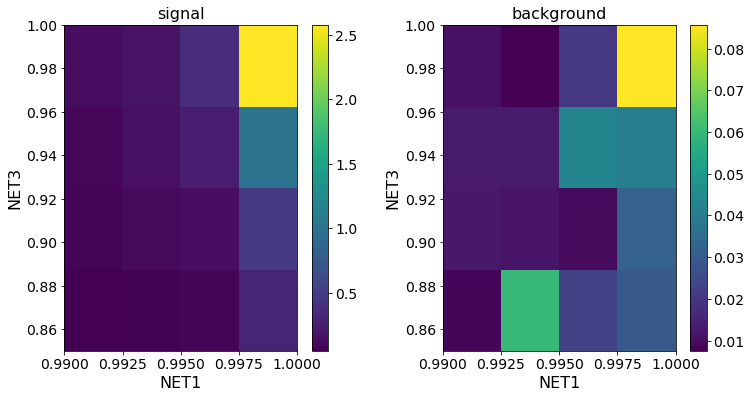

In [10]:
ana = Analysis(exp_df, livetime, net1_bins, net3_bins,
               astro_phi=ASTRO_PHI, astro_gamma=ASTRO_GAMMA,
               conv_model=conv_model,
               prompt_model=prompt_model,
               syst_slopes=syst_slopes,
               syst_widths=syst_widths,
               prior_types=prior_types,
               astro_norm_mean=astro_norm_mean,
               astro_norm_width=astro_norm_width,
               conv_norm_mean=conv_norm_mean,
               conv_norm_width=conv_norm_width,
               prompt_norm_mean=prompt_norm_mean,
               prompt_norm_width=prompt_norm_width,
               mg_norm_mean=mg_norm_mean,
               mg_norm_width=mg_norm_width)
ana.plot_templates()

In [11]:
ana.sig_hist.sum()

6.052687355499078

In [12]:
ana.bg_hist.sum()

0.4202664756909492

In [13]:
sample_hist = ana.sig_hist + ana.bg_hist

Text(0.5, 1.0, 'sample hist')

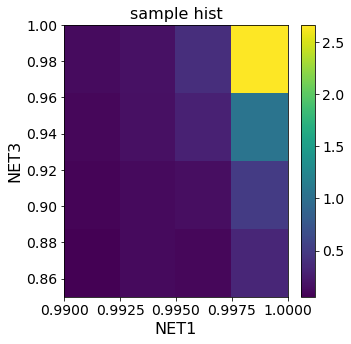

In [14]:
fig, ax = plt.subplots(figsize=(5, 5))
plotting.plot_hist(net1_bins, net3_bins, sample_hist, ax)
ax.set_title('sample hist')

### For each point in the flavor composition scan, I will fit the total flux. I will assign a prior width of 40% to the total flux

In [15]:
scan_pts = np.linspace(0, 2, 10000)
prior_width = 0.4
prior_penalty = (scan_pts - 1)**2/(prior_width**2)

In [16]:
conv_flux = nuflux.makeFlux(conv_model).getFlux
prompt_flux = nuflux.makeFlux(prompt_model).getFlux

In [17]:
def build_flav_template(f_e, f_mu):
    f_tau = 1 - f_e - f_mu
    scaled_df = exp_df.copy()
    
    astro_weight = lambda d: calc_astro_weights(d, ASTRO_PHI, ASTRO_GAMMA) * livetime
    atmos_weight = lambda d: (calc_atmos_weights(d, conv_flux) + calc_atmos_weights(d, prompt_flux)) * livetime
    muon_weight = lambda d: d.oneweight * livetime
    
    # just scale the CC and GR; the sum of NC components will always be the same
    not_nc_mask = (exp_df.it != 2)
    nu_mask = exp_df.pid != 0
    
    # tau CC
    tau_df = exp_df[(np.abs(exp_df.pid) == 16) & not_nc_mask]
    tau_template = f_tau * 3 * build_template(tau_df, net1_bins, net3_bins, "n1", "n3", astro_weight)
    # nu_mu CC
    mu_df = exp_df[(np.abs(exp_df.pid) == 14) & not_nc_mask]
    nu_mu_template = f_mu * 3 * build_template(mu_df, net1_bins, net3_bins, "n1", "n3", astro_weight)
    # nu_e CC & GR
    e_df = exp_df[(np.abs(exp_df.pid) == 12) & not_nc_mask]
    e_template = f_e * 3 * build_template(e_df, net1_bins, net3_bins, "n1", "n3", astro_weight)
    
    # NC template
    nc_df = exp_df[nu_mask & (~not_nc_mask)]
    nc_template = build_template(nc_df, net1_bins, net3_bins, "n1", "n3", astro_weight)
    
    # atmos template
    atmos = exp_df[nu_mask]
    atmos_template = build_template(atmos, net1_bins, net3_bins, "n1", "n3", atmos_weight)
    
    # muon template
    muon_df = exp_df[~nu_mask]
    muon_template = build_template(muon_df, net1_bins, net3_bins, "n1", "n3", muon_weight)
    muon_template *= mg_norm_mean
    
    astro_hist = tau_template + nu_mu_template + e_template + nc_template
    other_hist = atmos_template + muon_template
        
    return astro_hist, other_hist

In [18]:
astro, other = build_flav_template(1.0 / 3, 1.0 / 3)
(astro + other).sum()

6.472953831190028

In [19]:
(ana.sig_hist + ana.bg_hist).sum()

6.472953831190026

In [20]:
def test_composition(f_e, f_mu):
    test_astro, test_other = build_flav_template(f_e, f_mu)
    plotting.plot_hists(net1_bins, net3_bins, test_astro, test_other, ("astro", "atmos and muons"))
    
    nominal_llh_scan = -2*llh_scan(sample_hist, scan_pts, test_astro, test_other)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(scan_pts, nominal_llh_scan - nominal_llh_scan.min(), label='CNN LLH')
    ax.plot(scan_pts, prior_penalty - prior_penalty.min(), label='prior penalty')
    ax.plot(scan_pts, prior_penalty + nominal_llh_scan - (prior_penalty + nominal_llh_scan).min(), label='combined')

    ax.legend()

    ax.set_xlabel('total astro flux')
    ax.set_ylabel('$\Delta \chi^2$')

    print(f"Best LLH: {(prior_penalty + nominal_llh_scan).min()}")

Best LLH: 15.514818095492839


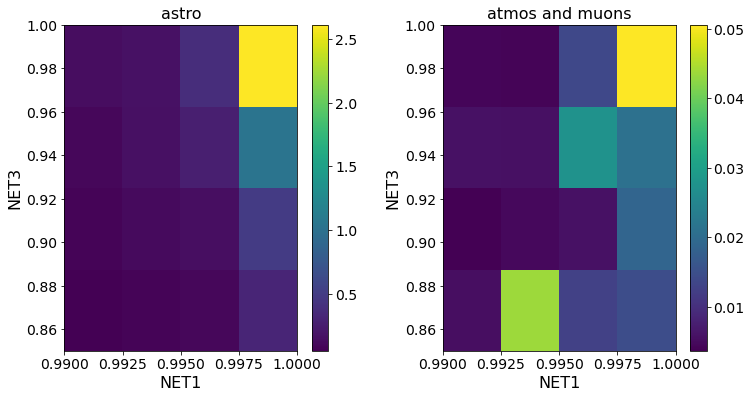

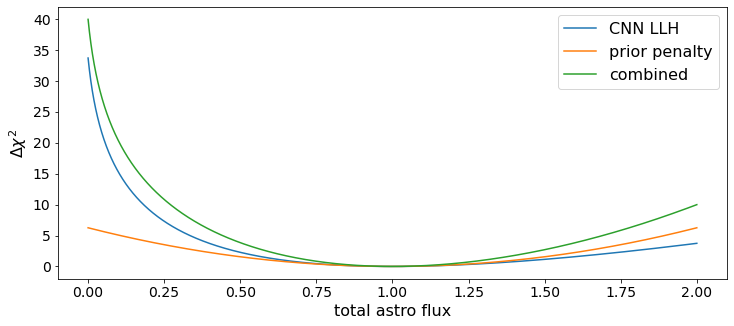

In [21]:
test_composition(1.0/3.0, 1.0/3.0)

Best LLH: 38.3107017788389


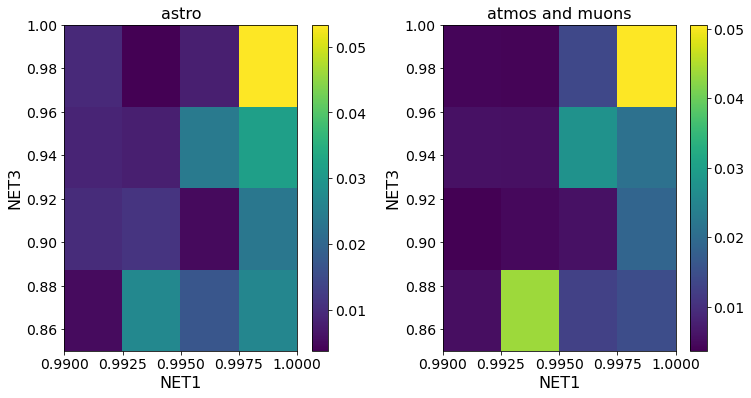

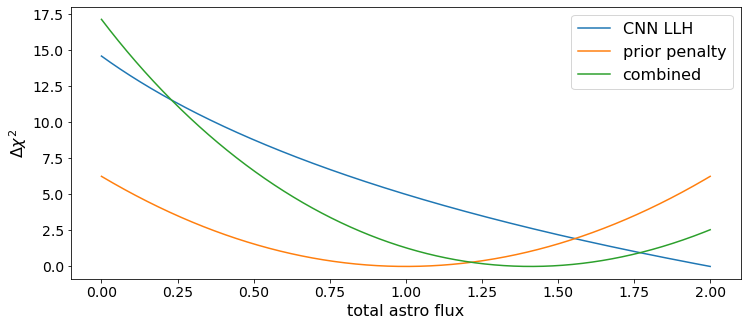

In [22]:
test_composition(1.0/3.0, 2.0/3.0)

### Evaluate at all points in the flavor composition space

In [23]:
inelf = 'inel_flav_scan_delta_llh.txt'
ineldt = {'names': ('nue', 'numu', 'nutau', 'llh'),
          'formats': (float, float, float, float)}
data=np.loadtxt(f'{prefix}/{inelf}', dtype=ineldt, skiprows = 1)

In [24]:
for row in data[:10]:
    print(row[['nue', 'numu']])

(0., 0.)
(0., 0.01666667)
(0., 0.03333333)
(0., 0.05)
(0., 0.06666667)
(0., 0.08333333)
(0., 0.1)
(0., 0.11666667)
(0., 0.13333333)
(0., 0.15)


In [25]:
%%time
scan_pts = np.linspace(0, 2, 10000)
cnn_llhs = []
combined_llhs = []
for row in data:
    f_e, f_mu = row[['nue', 'numu']]
    astro, other = build_flav_template(f_e, f_mu)
    nominal_llh_scan = -2*llh_scan(sample_hist, scan_pts, astro, other)
    best_llh = (nominal_llh_scan + prior_penalty).min()
    cnn_llhs.append(best_llh)
    combined_llhs.append(best_llh + row['llh'])
sample_cnn_llhs = np.vstack((cnn_llhs, combined_llhs)).T

CPU times: user 1min 39s, sys: 5.73 s, total: 1min 45s
Wall time: 1min 32s


In [26]:
sample_cnn_llhs.shape

(1877, 2)

In [27]:
np.save(f'cnn_flav_comp_scan_new_sim_{ASTRO_NAME}', sample_cnn_llhs)